## Fastmarch ORCA Policy

In [1]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            plt.figure("occupancy", figsize=[8,8]) 
            grid = self.map.occupancy()
            gridshow(self.field)
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
            plt.plot(gridfmpath8[:,0],  gridfmpath8[:,1] , '-o', color=plt.cm.winter(0.33) , mec=plt.cm.winter(0.33), mfc=[0,0,0,0])
            plt.show()
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            print("vx: ", joint_state.self_state.vx,"vy: ", joint_state.self_state.vy, "v: ",
                  np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2))
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                print("idx: ", idx)
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]) #, 0.1*(np.random.random()-0.5)

/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib

## Play Policy

In [2]:
import os

def play_policy(env, n_sequences, episode_length=1000,
                         subset_index=0, n_subsets=1,
                         render=True,
                         policy=FastmarchORCAPolicy(),
                         archive_dir=os.path.expanduser("~/navrep/datasets/V/ian")
                         ):
    """
    if n_subsets is None, the whole set of sequences is generated (n_sequences)
    if n_subsets is a number > 1, this function only generates a portion of the sequences
    """
    indices = np.arange(n_sequences)
    if n_subsets > 1:  # when multiprocessing
        indices = np.array_split(indices, n_subsets)[subset_index]
    scans = []
    robotstates = []
    actions = []
    rewards = []
    dones = []
    for n in indices:
        policy.reset()
        obs = env.reset()
        for i in range(episode_length):
            # step
            action = policy.predict(obs, env)
            if isinstance(action, Suicide):
                obs = env.reset()
                rew = 0
                action = np.array([0, 0, 0])
                done = True
            else:
                obs, rew, done, _ = env.step(action)
            scans.append(obs[0])
            robotstates.append(obs[1])
            actions.append(action)
            rewards.append(rew)
            dones.append(done)
            if render:
                env.render(save_to_file=True)
            if done:
                policy.reset()
                obs = env.reset()
        dones[-1] = True

    scans = np.array(scans)
    robotstates = np.array(robotstates)
    actions = np.array(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    data = dict(scans=scans, robotstates=robotstates, actions=actions, rewards=rewards, dones=dones)
        #if archive_dir is not None:
         #   make_dir_if_not_exists(archive_dir)
          #  archive_path = os.path.join(
           #     archive_dir, "{:03}_scans_robotstates_actions_rewards_dones.npz".format(n)
            #)
            #np.savez_compressed(archive_path, **data)
            #print(archive_path, "written.")
    env.close()
    return data

Ros was not found, disabled.


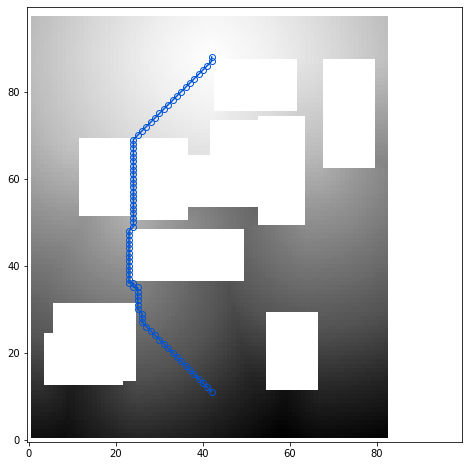

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1612429320812226 vy:  0.4019009470939637 v:  0.4330400148036839
vx:  -0.13595485687255854 vy:  0.5915743112564087 v:  0.6069957898089016
vx:  -0.3277016282081604 vy:  0.7354700565338135 v:  0.805173621766219
vx:  -0.44795095920562755 vy:  0.6690624356269836 v:  0.8051736487369376
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.48786535859107977 vy:  0.6405403614044191 v:  0.8051736227058774
vx:  -0.432746946811676 vy:  0.6789953112602235 v:  0.8051736164878948
vx:  -0.4425942897796632 vy:  0.6726179718971251 v:  0.8051736716166061
vx:  -0.444543302059173

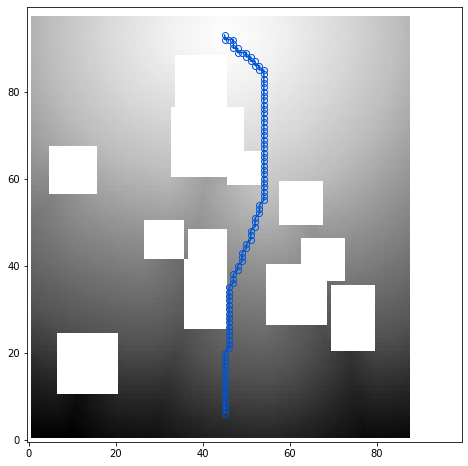

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.01762324571609497 vy:  0.4056414365768432 v:  0.4060240803914159
vx:  0.1394699960947039 vy:  0.8145341277122496 v:  0.8263883621025965
vx:  0.0353944227099417 vy:  0.8256300687789916 v:  0.8263883927252199
vx:  0.04731092602014575 vy:  0.8250328898429868 v:  0.8263882822520863
vx:  0.049766749143600686 vy:  0.8248884081840514 v:  0.826388295704108
vx:  0.049766764044761824 vy:  0.8248884677886963 v:  0.8263883560979487
vx:  0.049766764044761824 vy:  0.8248884677886963 v:  0.8263883560979487
vx:  0.04976675659418128 vy:  0.8248884081840514 v:  0.8263882961527969
vx:  0.049766764044761824 vy:  0.8248884677886963 v:  0.8263883560979487
vx:  0.049766749143600686 vy:  0.8248884081840514 v:  0.826388295704108
vx:  0.04976676031947114 vy:  0.8248884677886963 v:  0.8263883558736043
vx:  0.04976676031947164 vy:  0.8248884081840515 v:  0.8263882963771414
vx:  0.049766764044761824 vy:  0.8248884677886963 v:  0.8263883560979487
vx:  0.049766764044761824 vy

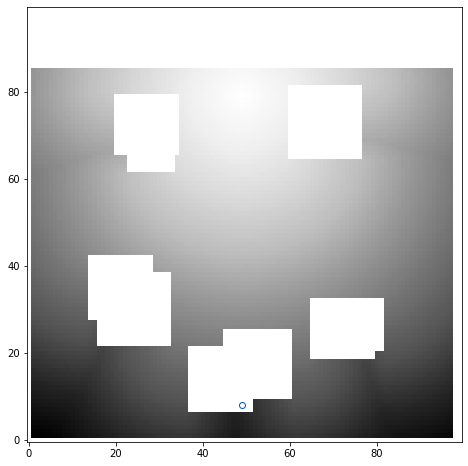

vx:  0.04333251714706422 vy:  0.06205210834741592 v:  0.0756846826819011
idx:  0
vx:  0.6265159249305725 vy:  0.059569977223873374 v:  0.6293415498583131
vx:  0.8395361900329591 vy:  0.15711371600627902 v:  0.8541110783337016
vx:  0.6845289468765259 vy:  0.12810514867305778 v:  0.6964128145205485
vx:  0.6562991142272948 vy:  0.12282191962003725 v:  0.6676928569894115
vx:  0.626169741153717 vy:  0.117183484137058 v:  0.6370404333250859
vx:  0.5943573713302612 vy:  0.1112300977110865 v:  0.604675797011453
vx:  0.5611652135849 vy:  0.10501849651336667 v:  0.570907419419046
vx:  0.5269721746444702 vy:  0.09861948341131224 v:  0.5361207656469167
vx:  0.4922133684158325 vy:  0.09211457520723344 v:  0.5007585196607933
vx:  0.37290775775909424 vy:  0.069787174463272 v:  0.3793816620719595
vx:  0.35209667682647705 vy:  0.06589251756668087 v:  0.358209287572955
vx:  0.40172627568244945 vy:  0.07518048584461211 v:  0.4087005089616641
vx:  0.30834096670150757 vy:  0.05770401656627668 v:  0.3136939

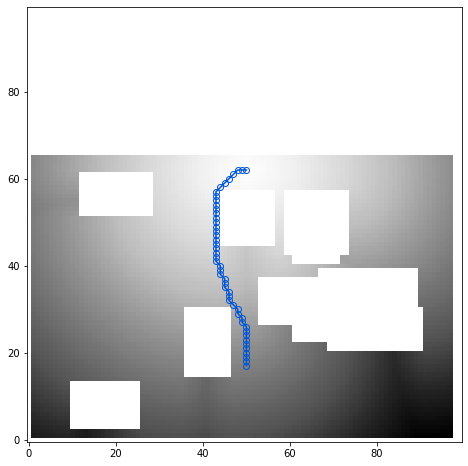

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.010735869407653587 vy:  0.4812292158603668 v:  0.4813489556335629
vx:  -0.023817412555217923 vy:  0.6267188787460328 v:  0.6271712861073202
vx:  0.008687812834977743 vy:  0.6885597109794617 v:  0.6886145174740186
vx:  0.04967799037694935 vy:  0.7385992407798767 v:  0.7402680198472055
vx:  0.10756488889455769 vy:  0.7848533987998961 v:  0.7921900421809449
vx:  0.04065337404608699 vy:  0.7531773447990416 v:  0.7542736967042305
vx:  0.020040618255734458 vy:  0.766340732574463 v:  0.7666027294386818
vx:  0.034213818609714855 vy:  0.8360614776611328 v:  0.8367612442105427
vx:  0.028921769931912034 vy:  0.8602899312973022 v:  0.8607759491688365
vx:  -0.06942910701036427 vy:  0.7032539844512938 v:  0.7066728858155499
vx:  -0.2987795174121854 vy:  0.7075453400611879 v:  0.768042712527995
vx:  -0.2946135401725772 vy:  0.7062196135520933 v:  0.765207998271507
vx:  -0.289419263601303 vy:  0.6904641389846803 v:  0.7486683093115244
vx:  -0.2875015139579773 

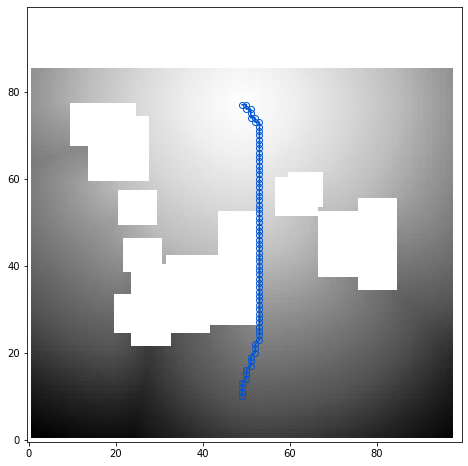

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  4.163336342344337e-17 vy:  0.6829988956451416 v:  0.6829988956451416
vx:  4.163336342344337e-17 vy:  0.6556788682937621 v:  0.6556788682937621
vx:  4.163336342344337e-17 vy:  0.6294516921043395 v:  0.6294516921043395
vx:  1.3877787807814457e-17 vy:  0.6042736172676085 v:  0.6042736172676085
vx:  4.163336342344337e-17 vy:  0.5801027417182922 v:  0.5801027417182922
vx:  2.7755575615628914e-17 vy:  0.5568986535072327 v:  0.5568986535072327
vx:  2.7755575615628914e-17 vy:  0.5346227288246155 v:  0.5346227288246155
vx:  2.7755575615628914e-17 vy:  0.5132377743721008 v:  0.5132377743721008
vx:  2.7755575615628914e-17 vy:  0.4927082657814026 v:  0.4927082657814026
vx:  2.7755575615628914e-17 vy:  0.4729998707771301 v:  0.4729998707771301
vx:  2.7755575615628914e-17 vy:  0.4540799260139465 v:  0.4540799260139465
vx:  2.7755575615628914e-17 vy:  0.43591672182083124 v:  0.43591672182083124
vx:  2.0816681711721685e-17 vy:  0.4184800386428833 v:  0.4184800386

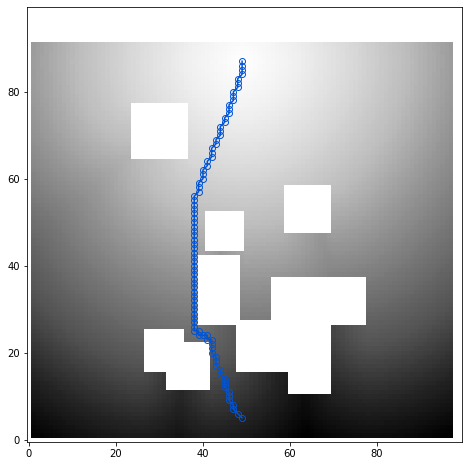

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.05384998023509975 vy:  0.47173780202865595 v:  0.4748014050465184
vx:  -0.28916227817535406 vy:  0.9419057369232179 v:  0.9852924643822417
vx:  -0.24304637312889107 vy:  0.9176592826843263 v:  0.9492997938416612
vx:  -0.24236854910850525 vy:  0.8809528350830079 v:  0.9136850722419357
vx:  -0.24115540087223059 vy:  0.845714807510376 v:  0.8794256438222384
vx:  -0.23937653005123138 vy:  0.811886191368103 v:  0.84643978573409
vx:  -0.18035219609737405 vy:  0.7794107198715211 v:  0.8000049905393019
vx:  -0.3760106265544892 vy:  0.7482343912124635 v:  0.8373999614730021
vx:  -0.43400108814239496 vy:  0.8954350948333741 v:  0.9950683160306315
vx:  -0.41827780008316046 vy:  0.9080663323402405 v:  0.9997703646199283
vx:  -0.4182670116424559 vy:  0.9080428481101992 v:  0.9997445208814063
vx:  -0.41825434565544123 vy:  0.908015251159668 v:  0.9997141561457537
vx:  -0.41823917627334595 vy:  0.9079824686050415 v:  0.999678034100936
vx:  -0.418221026659011

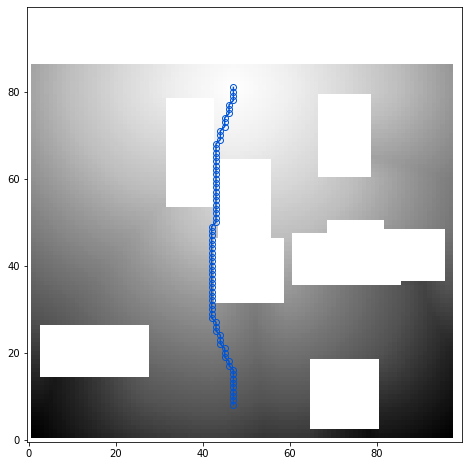

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.18090297281742113 vy:  0.6035665273666382 v:  0.6300939918231274
vx:  0.1547806560993194 vy:  0.8100647926330566 v:  0.8247193581856636
vx:  0.029235709458589595 vy:  0.824200987815857 v:  0.8247193431854146
vx:  -0.020208038389682714 vy:  0.8182196021080017 v:  0.8184691088180026
vx:  -0.019995242357254056 vy:  0.785490870475769 v:  0.7857453259916388
vx:  -0.01973485946655279 vy:  0.7540711760520935 v:  0.7543293731724571
vx:  -0.2336408197879792 vy:  0.7239083647727967 v:  0.7606782192617476
vx:  -0.264572262763977 vy:  0.781129777431488 v:  0.8247194743755096
vx:  -0.264572262763977 vy:  0.781129777431488 v:  0.8247194743755096
vx:  -0.19754937291145325 vy:  0.8007098436355592 v:  0.8247193513144881
vx:  -0.19754937291145325 vy:  0.8007098436355592 v:  0.8247193513144881
vx:  -0.19754937291145325 vy:  0.8007098436355592 v:  0.8247193513144881
vx:  -0.19754937291145325 vy:  0.8007098436355592 v:  0.8247193513144881
vx:  -0.19754937291145325 

vx:  0.00793834775686265 vy:  0.16549767553806305 v:  0.16568795361646205
idx:  0
vx:  0.0076208263635635445 vy:  0.16503931581974027 v:  0.16521517109730435
idx:  0
vx:  0.007315978407859813 vy:  0.164601743221283 v:  0.16476424797737357
idx:  0
vx:  0.0070233494043350185 vy:  0.1641840934753418 v:  0.16433424471842484
idx:  0
vx:  0.006742402911186239 vy:  0.16378554701805118 v:  0.16392426729749024
idx:  0
vx:  0.006472721695899963 vy:  0.16340535879135132 v:  0.16353350545953216
idx:  0
vx:  0.006213806569576277 vy:  0.163042739033699 v:  0.16316110487397106
idx:  0
vx:  0.0059652552008628915 vy:  0.162696972489357 v:  0.16280629326538335
idx:  0
vx:  0.005726650357246402 vy:  0.16236740350723267 v:  0.16246836075370077
idx:  0
vx:  0.0054975748062133685 vy:  0.16205330193042758 v:  0.1621465263127898
idx:  0
vx:  0.005277670919895162 vy:  0.16175413131713864 v:  0.16184020763858664
idx:  0
vx:  0.005066573619842522 vy:  0.1614692211151123 v:  0.16154869091319285
idx:  0
vx:  0.004

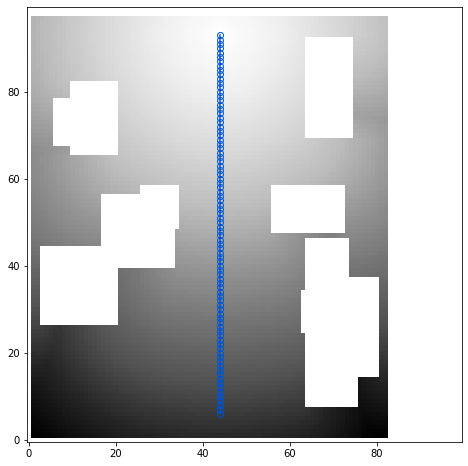

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.07203129678964615 vy:  0.4505576491355896 v:  0.4562791940378031
vx:  -0.05539705604314807 vy:  0.7972220182418823 v:  0.799144405090787
vx:  0.00568554038181901 vy:  0.8366780281066895 v:  0.8366973455712235
vx:  0.00568554038181901 vy:  0.8366780281066895 v:  0.8366973455712235
vx:  0.00568554038181901 vy:  0.8366780281066895 v:  0.8366973455712235
vx:  0.00568554038181901 vy:  0.8366780281066895 v:  0.8366973455712235
vx:  0.00568554038181901 vy:  0.8366780281066895 v:  0.8366973455712235
vx:  0.004232881125062732 vy:  0.8366867303848267 v:  0.836697437598963
vx:  0.004232881125062732 vy:  0.8366867303848267 v:  0.836697437598963
vx:  0.004232881125062732 vy:  0.8366867303848267 v:  0.836697437598963
vx:  0.004232881125062732 vy:  0.8366867303848267 v:  0.836697437598963
vx:  0.004232881125062732 vy:  0.8366867303848267 v:  0.836697437598963
vx:  0.0042328806594014445 vy:  0.8366867303848267 v:  0.8366974375966072
vx:  0.0031502489000558714 

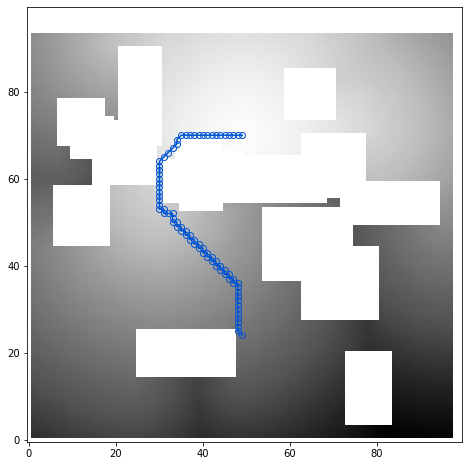

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.1193057000637053 vy:  0.5660268664360046 v:  0.5784637098341204
vx:  0.09929356724023802 vy:  0.7507486939430237 v:  0.7572864807669866
vx:  0.0351914167404177 vy:  0.9480221271514893 v:  0.9486750704962328
vx:  -0.18708583712577787 vy:  1.0214862823486328 v:  1.0384774121180893
vx:  -0.25649678707122825 vy:  0.9428308606147766 v:  0.977098067496535
vx:  -0.4051503837108614 vy:  0.9506424069404602 v:  1.0333769008907687
vx:  -0.38665711879730225 vy:  0.9126166105270386 v:  0.9911472167778567
vx:  -0.3179444670677185 vy:  0.8761119246482849 v:  0.9320197361911912
vx:  0.256282329559326 vy:  0.8410674333572388 v:  0.8792468708494152
vx:  0.15095436573028564 vy:  0.8924248218536376 v:  0.9051018081926085
vx:  0.17640742659568787 vy:  0.8567277193069458 v:  0.8747010719022779
vx:  0.26603901386261014 vy:  0.8224586844444274 v:  0.8644160135693045
vx:  0.25539749860763544 vy:  0.7895603775978088 v:  0.8298394255320916
vx:  0.2451815605163573 vy:  0.

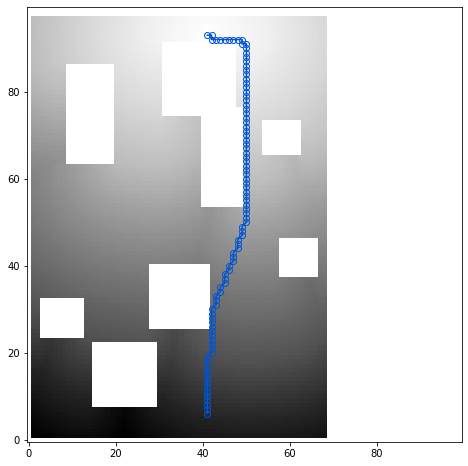

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.11950967460870743 vy:  0.3082262575626374 v:  0.33058431326387583
vx:  0.17888994514942164 vy:  0.5887243151664734 v:  0.6153031218381686
vx:  0.20527839660644534 vy:  0.814960777759552 v:  0.8404167355543124
vx:  0.11628447473049162 vy:  0.9722842574119569 v:  0.97921333542516
vx:  0.033292289823293575 vy:  0.9786471724510194 v:  0.9792132886700698


In [3]:
from navrep.envs.e2eenv import E2E1DNavRepEnv
env = E2E1DNavRepEnv(silent=True, scenario='train', adaptive=False, collect_statistics=False)
env.soadrl_sim.human_num = 5
#env.soadrl_sim.num_walls = 0
#env.soadrl_sim.num_circles = 0

data_reg = play_policy(env,1)

In [6]:
env.soadrl_sim.obstacle_vertices

[[(-1.9222712039705174, -5.322271203970518),
  (-4.077728796029483, -5.322271203970518),
  (-4.077728796029483, -7.477728796029483),
  (-1.9222712039705174, -7.477728796029483)],
 [(0.22671789043425028, 1.6267178904342505),
  (-0.8267178904342504, 1.6267178904342505),
  (-0.8267178904342504, 0.5732821095657498),
  (0.22671789043425028, 0.5732821095657498)],
 [(-1.2027019397565895, 2.697298060243411),
  (-3.197298060243411, 2.697298060243411),
  (-3.197298060243411, 0.7027019397565895),
  (-1.2027019397565895, 0.7027019397565895)],
 [(-1.013347616947582, -2.9133476169475823),
  (-1.986652383052418, -2.9133476169475823),
  (-1.986652383052418, -3.8866523830524184),
  (-1.013347616947582, -3.8866523830524184)],
 [(6.092999461024714, 1.0929994610247142),
  (4.7070005389752865, 1.0929994610247142),
  (4.7070005389752865, -0.2929994610247141),
  (6.092999461024714, -0.2929994610247141)],
 [(-1.280539896681852, 7.919460103318148),
  (-3.719460103318148, 7.919460103318148),
  (-3.7194601033181

[[22 10]]


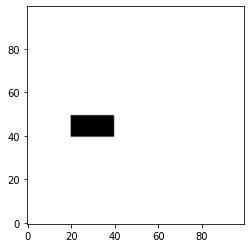

In [4]:
from map2d import gridshow

cmap2d = CMap2D.CMap2D()
cmap2d.set_resolution(0.1)
cmap2d.origin[0] = 0
cmap2d.origin[1] = 0
cmap2d._occupancy[20:40, 40:50] = 1.
coarse = cmap2d.as_coarse_map2d().as_coarse_map2d().as_coarse_map2d()

print(cmap2d.xy_to_ij([[2.26, 1.]]))

# occupancy
plt.figure("occupancy") 
grid = cmap2d.occupancy()
gridshow(grid)
plt.show()

In [5]:
env.reset()
i = 0
for vertex in env.soadrl_sim.obstacle_vertices:
    print(vertex)
    i+=1    
print(i)
env.render()

[(-1.9222712039705174, -5.322271203970518), (-4.077728796029483, -5.322271203970518), (-4.077728796029483, -7.477728796029483), (-1.9222712039705174, -7.477728796029483)]
[(0.22671789043425028, 1.6267178904342505), (-0.8267178904342504, 1.6267178904342505), (-0.8267178904342504, 0.5732821095657498), (0.22671789043425028, 0.5732821095657498)]
[(-1.2027019397565895, 2.697298060243411), (-3.197298060243411, 2.697298060243411), (-3.197298060243411, 0.7027019397565895), (-1.2027019397565895, 0.7027019397565895)]
[(-1.013347616947582, -2.9133476169475823), (-1.986652383052418, -2.9133476169475823), (-1.986652383052418, -3.8866523830524184), (-1.013347616947582, -3.8866523830524184)]
[(6.092999461024714, 1.0929994610247142), (4.7070005389752865, 1.0929994610247142), (4.7070005389752865, -0.2929994610247141), (6.092999461024714, -0.2929994610247141)]
[(-1.280539896681852, 7.919460103318148), (-3.719460103318148, 7.919460103318148), (-3.719460103318148, 5.480539896681853), (-1.280539896681852, 

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
i

In [ ]:
import numpy as np
np.array((1,2))

In [ ]:
amap = CMap2D.CMap2D()
print(dir(env.soadrl_sim.robot))

In [ ]:
data = data_reg
print(data['rewards'][data['rewards']>2].size)
print(data['dones'][data['dones']==True].size)

In [ ]:
#177

#182

# 283 augmented

# 232 not augmented